# OOTD 1st Go

Fine-tuning a Pretrained Network for OOTD safeguard


The advantage of this approach is that, since pre-trained networks are learned on a large set of images, the intermediate layers capture the "semantics" of the general visual appearance. Think of it as a very powerful generic visual feature that you can treat as a black box. On top of that, only a relatively small amount of data is needed for good performance on the target task.

First, we will need to prepare the data. This involves the following parts:
(1) Get the ImageNet ilsvrc pretrained model with the provided shell scripts.
(2) Prepare OOTD dataset for fine-tuning.
(3) Compile the downloaded OOTD dataset into a database that Caffe can then consume.

In [2]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

#caffe.set_device(0)
#caffe.set_mode_gpu()
#switched to cpu mode.  SJP

caffe.set_mode_cpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

### 1. Setup and dataset download

Download data required for this exercise.

- `get_ilsvrc_aux.sh` to download the ImageNet data mean, labels, etc.
- `download_model_binary.py` to download the pretrained reference model
- `finetune_flickr_style/assemble_data.py` downloadsd the style training and testing data

We'll download just a small subset of the full dataset for this exercise: just 2000 of the 80K images, from 5 of the 20 style categories.  (To download the full dataset, set `full_dataset = True` in the cell below.)

In [3]:
# Download just a small subset of the data for this exercise.
# (2000 of 80K images, 5 of 20 labels.)
# To download the entire dataset, set `full_dataset = True`.
full_dataset = False
if full_dataset:
    NUM_OOTD_IMAGES = NUM_OOTD_LABELS = -1
else:
    NUM_OOTD_IMAGES = 4900
    NUM_OOTD_LABELS = 3

# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.
import os
os.chdir(caffe_root)  # run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet
!python examples/finetune_flickr_style/assemble_data_ootd.py \
#    --workers=-1  --seed=1701 \
#    --images=$NUM_OOTD_IMAGES  --label=$NUM_STYLE_LABELS
    
print NUM_OOTD_IMAGES, NUM_OOTD_LABELS

# back to examples
os.chdir('examples')

Downloading...
--2016-06-14 15:57:35--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: 'caffe_ilsvrc12.tar.gz'

caffe_ilsvrc12.tar. 100%[===================>]  17.03M  2.51MB/s    in 5.8s    

2016-06-14 15:57:41 (2.92 MB/s) - 'caffe_ilsvrc12.tar.gz' saved [17858008/17858008]

Unzipping...
Done.
Model already exists.
Done
4900 3


Define `weights`, the path to the ImageNet pretrained weights we just downloaded, and make sure it exists.

In [4]:
import os
weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
assert os.path.exists(weights)

Load the 1000 ImageNet labels from `ilsvrc12/synset_words.txt`, and the 5 style labels from `finetune_flickr_style/style_names.txt`.

In [5]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

# Load style labels to style_labels
ootd_label_file = caffe_root + 'examples/finetune_flickr_style/ootd_names.txt'
ootd_labels = list(np.loadtxt(ootd_label_file, str, delimiter='\n'))
if NUM_OOTD_LABELS > 0:
    ootd_labels = ootd_labels[:NUM_OOTD_LABELS]
print '\nLoaded ootd labels:\n', ', '.join(ootd_labels)

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...

Loaded ootd labels:
Delete, Keep, Feature


### 2.  Defining and running the nets

We'll start by defining `caffenet`, a function which initializes the *CaffeNet* architecture (a minor variant on *AlexNet*), taking arguments specifying the data and number of output classes.

In [24]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

Now, let's create a *CaffeNet* that takes unlabeled "dummy data" as input, allowing us to set its input images externally and see what ImageNet classes it predicts.

In [25]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

Define a function `style_net` which calls `caffenet` on data from the Flickr style dataset.

The new network will also have the *CaffeNet* architecture, with differences in the input and output:

- the input is the Flickr style data we downloaded, provided by an `ImageData` layer
- the output is a distribution over 20 classes rather than the original 1000 ImageNet classes
- the classification layer is renamed from `fc8` to `fc8_flickr` to tell Caffe not to load the original classifier (`fc8`) weights from the ImageNet-pretrained model

In [26]:
def ootd_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = caffe_root + 'data/ootd/%s.txt' % subset
    transform_param = dict(mirror=train, crop_size=227,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    ootd_data, ootd_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=ootd_data, label=ootd_label, train=train,
                    num_classes=NUM_OOTD_LABELS,
                    classifier_name='fc8_ootd',
                    learn_all=learn_all)


Use the `style_net` function defined above to initialize `untrained_style_net`, a *CaffeNet* with input images from the style dataset and weights from the pretrained ImageNet model.


Call `forward` on `untrained_style_net` to get a batch of style training data.

In [27]:
untrained_ootd_net = caffe.Net(ootd_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_ootd_net.forward()
ootd_data_batch = untrained_ootd_net.blobs['data'].data.copy()
ootd_label_batch = np.array(untrained_ootd_net.blobs['label'].data, dtype=np.int32)
print ootd_label_batch.shape

(50,)


Pick one of the style net training images from the batch of 50 (we'll arbitrarily choose #8 here).  Display it, then run it through `imagenet_net`, the ImageNet-pretrained network to view its top 5 predicted classes from the 1000 ImageNet classes.

Below we chose an image where the network's predictions happen to be reasonable, as the image is of a beach, and "sandbar" and "seashore" both happen to be ImageNet-1000 categories.  For other images, the predictions won't be this good, sometimes due to the network actually failing to recognize the object(s) present in the image, but perhaps even more often due to the fact that not all images contain an object from the (somewhat arbitrarily chosen) 1000 ImageNet categories. Modify the `batch_index` variable by changing its default setting of 8 to another value from 0-49 (since the batch size is 50) to see predictions for other images in the batch.  (To go beyond this batch of 50 images, first rerun the *above* cell to load a fresh batch of data into `style_net`.)

In [17]:
def disp_preds(net, image, labels, k=3, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_ootd_preds(net, image):
    disp_preds(net, image, ootd_labels, name='ootd')

actual label = Keep


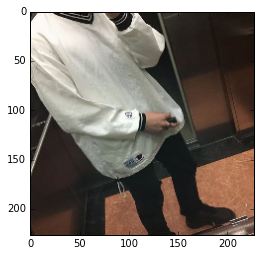

In [18]:
batch_index = 8
image = ootd_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[ootd_label_batch[batch_index]]

In [19]:
disp_imagenet_preds(imagenet_net, image)

top 3 predicted ImageNet labels =
	(1) 20.82% n01494475 hammerhead, hammerhead shark
	(2)  7.88% n04350905 suit, suit of clothes
	(3)  5.59% n04162706 seat belt, seatbelt


We can also look at `untrained_style_net`'s predictions, but we won't see anything interesting as its classifier hasn't been trained yet.

In fact, since we zero-initialized the classifier (see `caffenet` definition -- no `weight_filler` is passed to the final `InnerProduct` layer), the softmax inputs should be all zero and we should therefore see a predicted probability of 1/N for each label (for N labels).  Since we set N = 5, we get a predicted probability of 20% for each class.

In [20]:
disp_ootd_preds(untrained_ootd_net, image)

top 3 predicted ootd labels =
	(1) 33.33% Delete
	(2) 33.33% Keep
	(3) 33.33% Feature


We can also verify that the activations in layer `fc7` immediately before the classification layer are the same as (or very close to) those in the ImageNet-pretrained model, since both models are using the same pretrained weights in the `conv1` through `fc7` layers.

In [21]:
diff = untrained_ootd_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

Delete `untrained_style_net` to save memory.  (Hang on to `imagenet_net` as we'll use it again later.)

In [22]:
del untrained_ootd_net

### 3. Training the style classifier

Now, we'll define a function `solver` to create our Caffe solvers, which are used to train the network (learn its weights).  In this function we'll set values for various parameters used for learning, display, and "snapshotting" -- see the inline comments for explanations of what they mean.  You may want to play with some of the learning parameters to see if you can improve on the results here!

In [23]:
from caffe.proto import caffe_pb2


def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = caffe_root + 'models/finetune_ootd/finetune_ootd'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

Now we'll invoke the solver to train the style net's classification layer.

For the record, if you want to train the network using only the command line tool, this is the command:

<code>
build/tools/caffe train \
    -solver models/finetune_flickr_style/solver.prototxt \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0
</code>

However, we will train using Python in this example.

We'll first define `run_solvers`, a function that takes a list of solvers and steps each one in a round robin manner, recording the accuracy and loss values each iteration.  At the end, the learned weights are saved to a file.

In [24]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

Let's create and run solvers to train nets for the style recognition task.  We'll create two solvers -- one (`style_solver`) will have its train net initialized to the ImageNet-pretrained weights (this is done by the call to the `copy_from` method), and the other (`scratch_style_solver`) will start from a *randomly* initialized net.

During training, we should see that the ImageNet pretrained net is learning faster and attaining better accuracies than the scratch net.

In [25]:
niter = 200  # number of iterations to train

# Reset style_solver as before.
ootd_solver_filename = solver(ootd_net(train=True))
ootd_solver = caffe.get_solver(ootd_solver_filename)
ootd_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_ootd_solver_filename = solver(ootd_net(train=True))
scratch_ootd_solver = caffe.get_solver(scratch_ootd_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', ootd_solver),
           ('scratch', scratch_ootd_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
ootd_weights, scratch_ootd_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del ootd_solver, scratch_ootd_solver, solvers

Running solvers for 200 iterations...
  0) pretrained: loss=1.099, acc= 6%; scratch: loss=1.099, acc= 6%
 10) pretrained: loss=0.721, acc=72%; scratch: loss=0.910, acc=54%
 20) pretrained: loss=0.373, acc=84%; scratch: loss=0.783, acc=58%
 30) pretrained: loss=0.571, acc=82%; scratch: loss=0.694, acc=72%
 40) pretrained: loss=0.740, acc=82%; scratch: loss=0.920, acc=66%
 50) pretrained: loss=0.601, acc=76%; scratch: loss=0.812, acc=68%
 60) pretrained: loss=0.697, acc=70%; scratch: loss=0.820, acc=50%
 70) pretrained: loss=0.533, acc=76%; scratch: loss=0.722, acc=66%
 80) pretrained: loss=0.361, acc=82%; scratch: loss=0.694, acc=62%
 90) pretrained: loss=0.621, acc=78%; scratch: loss=0.682, acc=64%
100) pretrained: loss=0.440, acc=86%; scratch: loss=0.701, acc=60%
110) pretrained: loss=0.552, acc=80%; scratch: loss=0.702, acc=70%
120) pretrained: loss=0.621, acc=76%; scratch: loss=0.828, acc=58%
130) pretrained: loss=0.519, acc=88%; scratch: loss=0.610, acc=80%
140) pretrained: loss=0.

Let's look at the training loss and accuracy produced by the two training procedures.  Notice how quickly the ImageNet pretrained model's loss value (blue) drops, and that the randomly initialized model's loss value (green) barely (if at all) improves from training only the classifier layer.

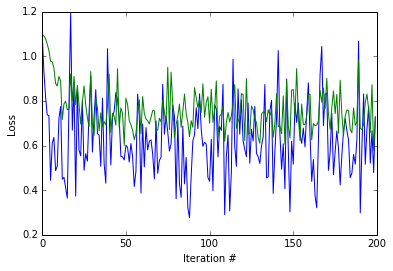

In [26]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

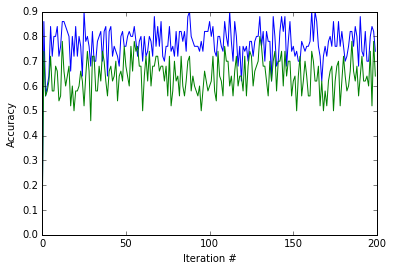

In [27]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

Let's take a look at the testing accuracy after running 200 iterations of training. Note that we're classifying among 5 classes, giving chance accuracy of 20%. We expect both results to be better than chance accuracy (20%), and we further expect the result from training using the ImageNet pretraining initialization to be much better than the one from training from scratch. Let's see.

In [28]:
def eval_ootd_net(weights, test_iters=10):
    test_net = caffe.Net(ootd_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [29]:
test_net, accuracy = eval_ootd_net(ootd_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_ootd_net(scratch_ootd_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, trained from ImageNet initialization: 77.8%
Accuracy, trained from   random initialization: 64.2%


### 4. End-to-end finetuning for style

Finally, we'll train both nets again, starting from the weights we just learned.  The only difference this time is that we'll be learning the weights "end-to-end" by turning on learning in *all* layers of the network, starting from the RGB `conv1` filters directly applied to the input image.  We pass the argument `learn_all=True` to the `style_net` function defined earlier in this notebook, which tells the function to apply a positive (non-zero) `lr_mult` value for all parameters.  Under the default, `learn_all=False`, all parameters in the pretrained layers (`conv1` through `fc7`) are frozen (`lr_mult = 0`), and we learn only the classifier layer `fc8_flickr`.

Note that both networks start at roughly the accuracy achieved at the end of the previous training session, and improve significantly with end-to-end training.  To be more scientific, we'd also want to follow the same additional training procedure *without* the end-to-end training, to ensure that our results aren't better simply because we trained for twice as long.  Feel free to try this yourself!

In [30]:
end_to_end_net = ootd_net(train=True, learn_all=True)

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 1e-5
niter = 20000

ootd_solver_filename = solver(end_to_end_net, base_lr=base_lr)
ootd_solver = caffe.get_solver(ootd_solver_filename)
ootd_solver.net.copy_from(ootd_weights)

scratch_ootd_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_ootd_solver = caffe.get_solver(scratch_ootd_solver_filename)
scratch_ootd_solver.net.copy_from(scratch_ootd_weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained, end-to-end', ootd_solver),
           ('scratch, end-to-end', scratch_ootd_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

ootd_weights_ft = finetuned_weights['pretrained, end-to-end']
scratch_ootd_weights_ft = finetuned_weights['scratch, end-to-end']

# Delete solvers to save memory.
del ootd_solver, scratch_ootd_solver, solvers

Running solvers for 20000 iterations...
  0) pretrained, end-to-end: loss=0.603, acc=72%; scratch, end-to-end: loss=0.955, acc=48%
 10) pretrained, end-to-end: loss=0.538, acc=76%; scratch, end-to-end: loss=0.854, acc=54%
 20) pretrained, end-to-end: loss=0.461, acc=80%; scratch, end-to-end: loss=0.725, acc=58%
 30) pretrained, end-to-end: loss=0.658, acc=80%; scratch, end-to-end: loss=0.672, acc=72%
 40) pretrained, end-to-end: loss=0.527, acc=82%; scratch, end-to-end: loss=0.922, acc=66%
 50) pretrained, end-to-end: loss=0.620, acc=78%; scratch, end-to-end: loss=0.801, acc=68%
 60) pretrained, end-to-end: loss=0.662, acc=72%; scratch, end-to-end: loss=0.784, acc=50%
 70) pretrained, end-to-end: loss=0.490, acc=78%; scratch, end-to-end: loss=0.722, acc=66%
 80) pretrained, end-to-end: loss=0.420, acc=80%; scratch, end-to-end: loss=0.695, acc=62%
 90) pretrained, end-to-end: loss=0.594, acc=80%; scratch, end-to-end: loss=0.680, acc=64%
100) pretrained, end-to-end: loss=0.394, acc=90%; 

In [ ]:
#added to evaluate params





Let's now test the end-to-end finetuned models.  Since all layers have been optimized for the style recognition task at hand, we expect both nets to get better results than the ones above, which were achieved by nets with only their classifier layers trained for the style task (on top of either ImageNet pretrained or randomly initialized weights).

In [31]:
test_net, accuracy = eval_ootd_net(ootd_weights_ft)
print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_ootd_net(scratch_ootd_weights_ft)
print 'Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, finetuned from ImageNet initialization: 79.6%
Accuracy, finetuned from   random initialization: 64.2%


We'll first look back at the image we started with and check our end-to-end trained model's predictions.

top 3 predicted ootd labels =
	(1) 97.05% Keep
	(2)  2.73% Delete
	(3)  0.21% Feature


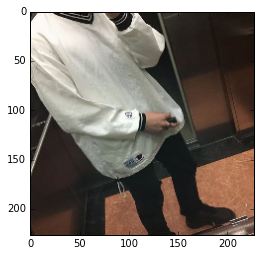

In [32]:
plt.imshow(deprocess_net_image(image))
disp_ootd_preds(test_net, image)

Whew, that looks a lot better than before!  But note that this image was from the training set, so the net got to see its label at training time.

Finally, we'll pick an image from the test set (an image the model hasn't seen) and look at our end-to-end finetuned style model's predictions for it.

top 3 predicted ootd labels =
	(1) 73.64% Keep
	(2) 24.32% Delete
	(3)  2.04% Feature
actual label = Delete
top 3 predicted ootd labels =
	(1) 73.64% Keep
	(2) 24.32% Delete
	(3)  2.04% Feature
actual label = Keep
top 3 predicted ootd labels =
	(1) 98.00% Delete
	(2)  1.26% Keep
	(3)  0.74% Feature
actual label = Delete
top 3 predicted ootd labels =
	(1) 78.46% Keep
	(2) 13.22% Feature
	(3)  8.32% Delete
actual label = Keep
top 3 predicted ootd labels =
	(1) 85.99% Keep
	(2)  7.06% Delete
	(3)  6.95% Feature
actual label = Keep
top 3 predicted ootd labels =
	(1) 78.69% Keep
	(2) 17.43% Delete
	(3)  3.88% Feature
actual label = Keep
top 3 predicted ootd labels =
	(1) 49.47% Keep
	(2) 46.19% Delete
	(3)  4.34% Feature
actual label = Keep
top 3 predicted ootd labels =
	(1) 88.29% Delete
	(2)  9.89% Keep
	(3)  1.82% Feature
actual label = Delete
top 3 predicted ootd labels =
	(1) 61.08% Delete
	(2) 34.86% Keep
	(3)  4.06% Feature
actual label = Delete
top 3 predicted ootd labels =
	(1) 72.

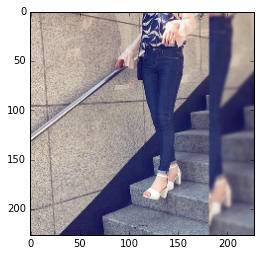

In [44]:
batch_index = 1
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]

In [34]:
with open('../models/finetune_ootd/deploy.prototxt', 'w') as f:
    f.write(str(ootd_net()))

In [38]:
with open('../models/finetune_ootd/test_net.prototxt', 'w') as f:
    f.write(str(test_net))

In [39]:
print test_net.blobs['data'].data.shape

(50, 3, 227, 227)


In [40]:
print test_net.blobs['data'].shape

In [41]:
disp_ootd_preds(test_net, image)

top 3 predicted ootd labels =
	(1) 73.64% Keep
	(2) 24.32% Delete
	(3)  2.04% Feature


We can also look at the predictions of the network trained from scratch.  We see that in this case, the scratch network also predicts the correct label for the image (*Pastel*), but is much less confident in its prediction than the pretrained net.

In [42]:
disp_ootd_preds(scratch_test_net, image)

top 3 predicted ootd labels =
	(1) 64.89% Keep
	(2) 32.55% Delete
	(3)  2.56% Feature


Of course, we can again look at the ImageNet model's predictions for the above image:

In [43]:
disp_imagenet_preds(imagenet_net, image)

top 3 predicted ImageNet labels =
	(1) 10.91% n03617480 kimono
	(2) 10.80% n02817516 bearskin, busby, shako
	(3)  6.02% n03325584 feather boa, boa


actual label = Delete
top 3 predicted ootd labels =
	(1) 98.00% Delete
	(2)  1.26% Keep
	(3)  0.74% Feature


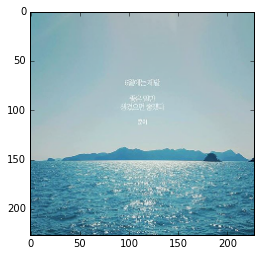

In [45]:
batch_index = 2
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 78.46% Keep
	(2) 13.22% Feature
	(3)  8.32% Delete


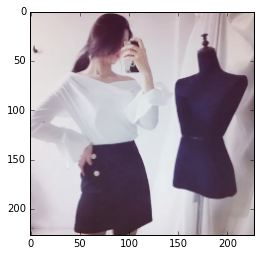

In [47]:
batch_index = 3
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 85.99% Keep
	(2)  7.06% Delete
	(3)  6.95% Feature


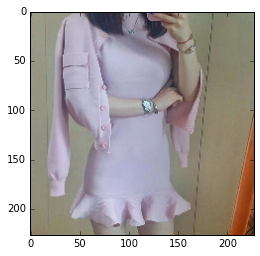

In [48]:
batch_index = 4
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 78.69% Keep
	(2) 17.43% Delete
	(3)  3.88% Feature


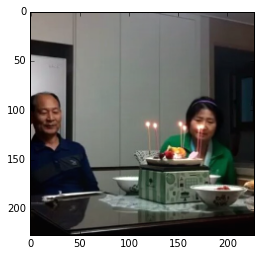

In [49]:
batch_index = 5
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 49.47% Keep
	(2) 46.19% Delete
	(3)  4.34% Feature


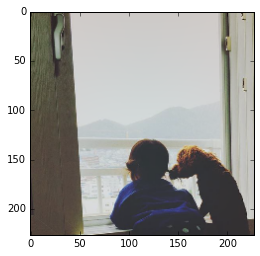

In [50]:
batch_index = 6
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 88.29% Delete
	(2)  9.89% Keep
	(3)  1.82% Feature


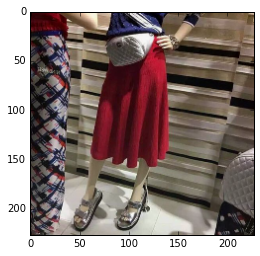

In [51]:
batch_index = 7
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 61.08% Delete
	(2) 34.86% Keep
	(3)  4.06% Feature


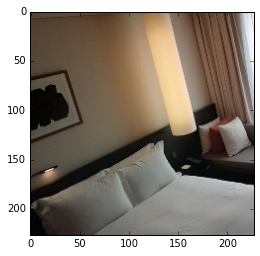

In [52]:
batch_index = 8
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 72.22% Keep
	(2) 21.51% Delete
	(3)  6.26% Feature


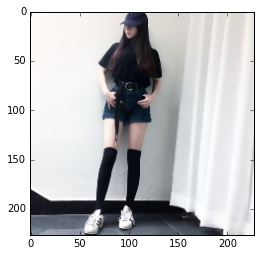

In [53]:
batch_index = 9
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 97.74% Delete
	(2)  2.24% Keep
	(3)  0.02% Feature


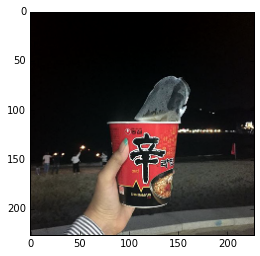

In [54]:
batch_index = 10
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 91.75% Delete
	(2)  7.16% Keep
	(3)  1.09% Feature


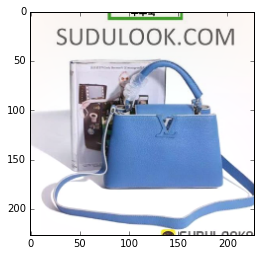

In [55]:
batch_index = 11
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 81.88% Keep
	(2) 13.29% Delete
	(3)  4.83% Feature


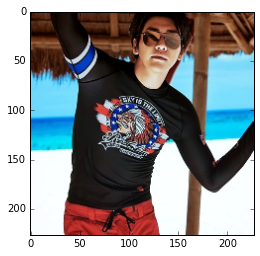

In [56]:
batch_index = 12
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 94.19% Keep
	(2)  5.11% Feature
	(3)  0.71% Delete


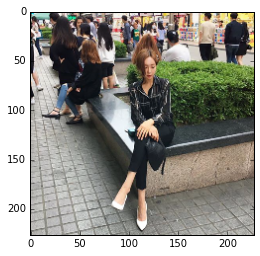

In [57]:
batch_index = 13
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 99.81% Delete
	(2)  0.18% Keep
	(3)  0.02% Feature


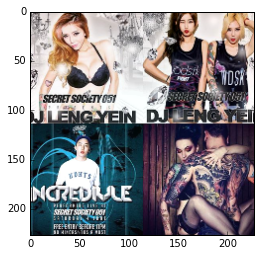

In [58]:
batch_index = 14
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 97.00% Keep
	(2)  2.73% Feature
	(3)  0.27% Delete


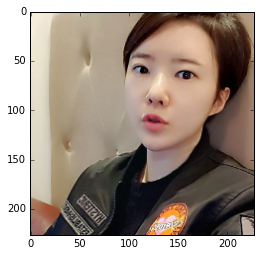

In [59]:
batch_index = 15
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 97.41% Delete
	(2)  2.52% Keep
	(3)  0.08% Feature


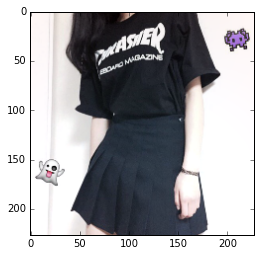

In [60]:
batch_index = 16
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 99.20% Keep
	(2)  0.68% Feature
	(3)  0.12% Delete


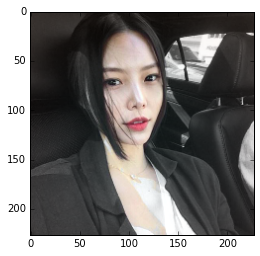

In [61]:
batch_index = 17
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 99.87% Delete
	(2)  0.13% Keep
	(3)  0.00% Feature


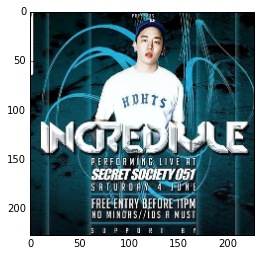

In [62]:
batch_index = 18
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 63.84% Delete
	(2) 35.71% Keep
	(3)  0.45% Feature


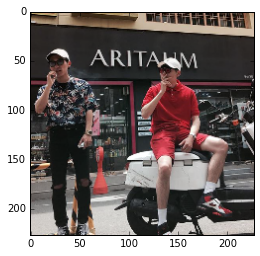

In [63]:
batch_index = 19
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 96.43% Keep
	(2)  1.83% Delete
	(3)  1.74% Feature


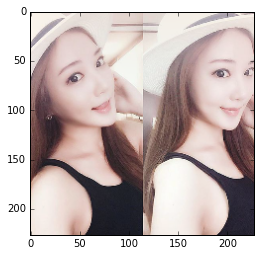

In [64]:
batch_index = 20
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 90.96% Keep
	(2)  8.02% Delete
	(3)  1.02% Feature


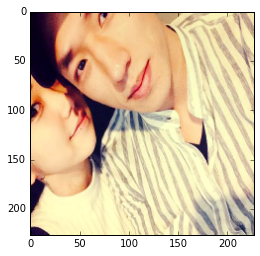

In [65]:
batch_index = 21
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 94.49% Keep
	(2)  5.18% Feature
	(3)  0.33% Delete


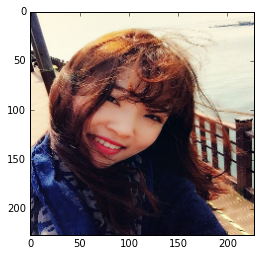

In [66]:
batch_index = 22
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 94.46% Delete
	(2)  5.25% Keep
	(3)  0.30% Feature


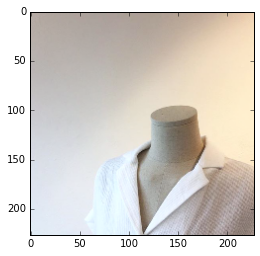

In [67]:
batch_index = 23
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 98.13% Keep
	(2)  1.68% Feature
	(3)  0.19% Delete


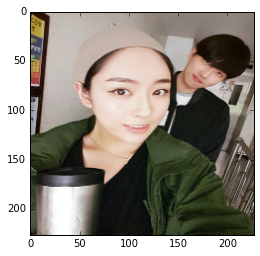

In [68]:
batch_index = 24
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 95.36% Keep
	(2)  4.10% Delete
	(3)  0.55% Feature


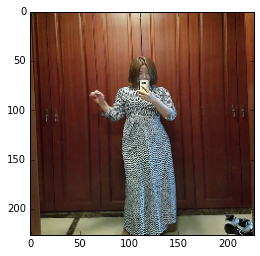

In [69]:
batch_index = 25
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 73.68% Delete
	(2) 25.30% Keep
	(3)  1.02% Feature


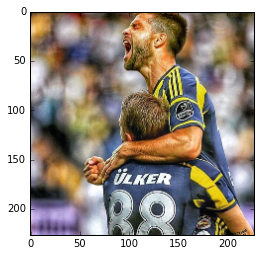

In [70]:
batch_index = 26
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 96.95% Keep
	(2)  2.44% Feature
	(3)  0.60% Delete


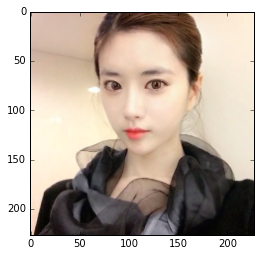

In [71]:
batch_index = 27
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 98.74% Keep
	(2)  1.02% Delete
	(3)  0.24% Feature


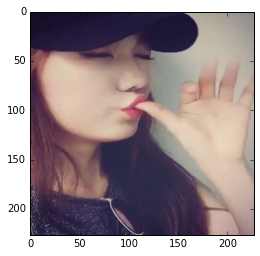

In [72]:
batch_index = 28
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 98.66% Keep
	(2)  1.13% Feature
	(3)  0.20% Delete


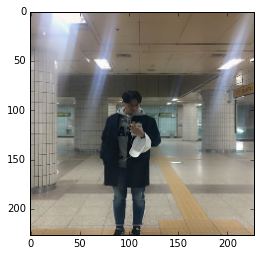

In [73]:
batch_index = 29
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 88.70% Keep
	(2) 10.65% Delete
	(3)  0.65% Feature


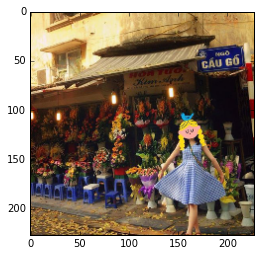

In [74]:
batch_index = 30
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 96.55% Keep
	(2)  1.96% Delete
	(3)  1.49% Feature


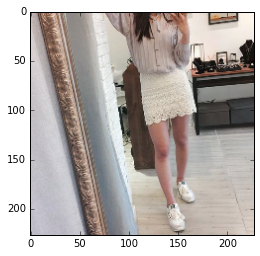

In [75]:
batch_index = 31
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 84.58% Keep
	(2) 15.16% Feature
	(3)  0.26% Delete


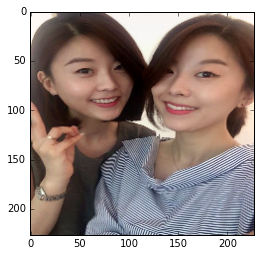

In [76]:
batch_index = 32
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 92.48% Keep
	(2)  3.84% Delete
	(3)  3.68% Feature


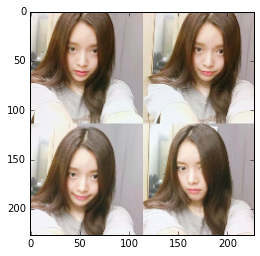

In [77]:
batch_index = 33
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 99.90% Delete
	(2)  0.09% Keep
	(3)  0.00% Feature


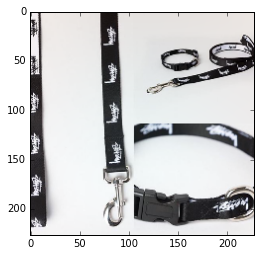

In [78]:
batch_index = 34
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 60.81% Delete
	(2) 38.80% Keep
	(3)  0.39% Feature


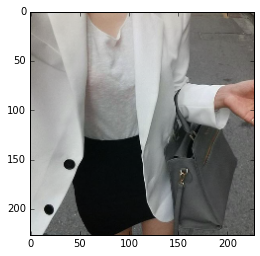

In [79]:
batch_index = 35
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 86.94% Keep
	(2) 11.41% Delete
	(3)  1.65% Feature


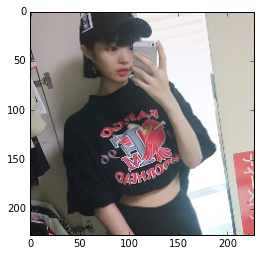

In [80]:
batch_index = 36
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 48.90% Delete
	(2) 44.67% Keep
	(3)  6.43% Feature


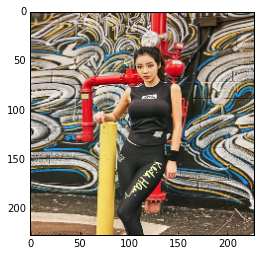

In [81]:
batch_index = 37
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 96.51% Keep
	(2)  2.30% Feature
	(3)  1.18% Delete


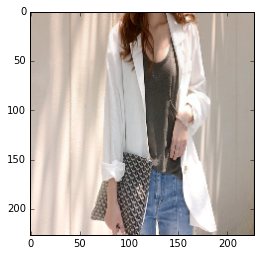

In [82]:
batch_index = 38
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Feature
top 3 predicted ootd labels =
	(1) 56.69% Keep
	(2) 31.12% Delete
	(3) 12.19% Feature


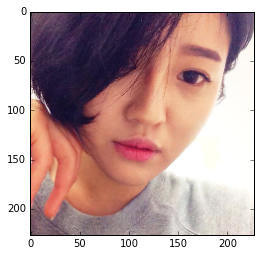

In [83]:
batch_index = 39
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 98.64% Delete
	(2)  1.22% Keep
	(3)  0.14% Feature


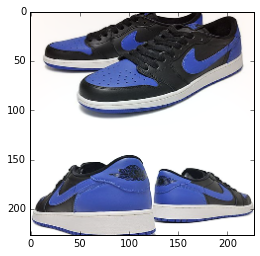

In [84]:
batch_index = 40
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 79.10% Keep
	(2) 20.35% Delete
	(3)  0.56% Feature


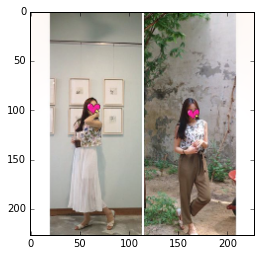

In [85]:
batch_index = 41
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 98.08% Keep
	(2)  1.19% Feature
	(3)  0.73% Delete


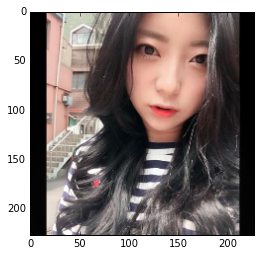

In [86]:
batch_index = 42
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 96.63% Keep
	(2)  1.73% Delete
	(3)  1.64% Feature


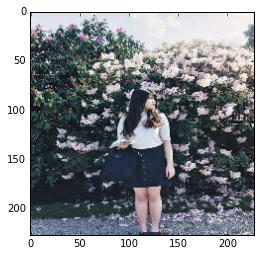

In [87]:
batch_index = 43
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 91.36% Keep
	(2)  5.15% Feature
	(3)  3.48% Delete


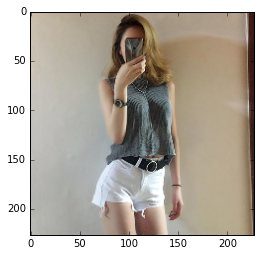

In [88]:
batch_index = 44
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 91.36% Keep
	(2)  6.30% Feature
	(3)  2.34% Delete


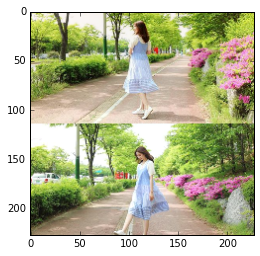

In [89]:
batch_index = 45
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 96.48% Keep
	(2)  1.84% Feature
	(3)  1.68% Delete


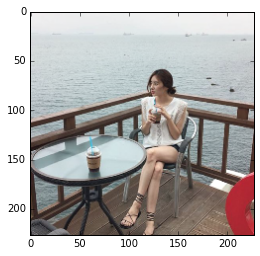

In [90]:
batch_index = 46
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 97.53% Keep
	(2)  1.65% Delete
	(3)  0.82% Feature


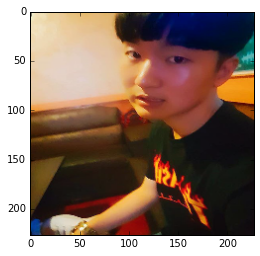

In [91]:
batch_index = 47
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 79.12% Keep
	(2) 18.81% Delete
	(3)  2.07% Feature


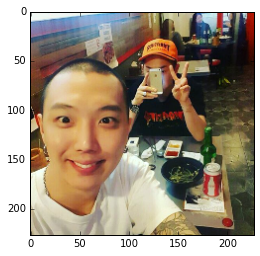

In [92]:
batch_index = 48
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 52.53% Delete
	(2) 45.88% Keep
	(3)  1.59% Feature


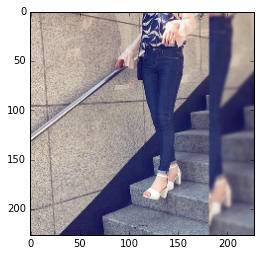

In [93]:
batch_index = 49
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

In [94]:
test_net.forward()

{'acc': array(0.8399999737739563, dtype=float32),
 'loss': array(0.42648231983184814, dtype=float32),
 'probs': array([[  2.29568835e-02,   9.35513794e-01,   4.15293686e-02],
        [  4.29950386e-01,   4.75967228e-01,   9.40823555e-02],
        [  1.15826868e-01,   7.09425807e-01,   1.74747407e-01],
        [  2.42750123e-01,   7.30469406e-01,   2.67804544e-02],
        [  9.99746740e-01,   2.46647338e-04,   6.55960957e-06],
        [  9.88850296e-01,   1.03422888e-02,   8.07321980e-04],
        [  4.07400317e-02,   9.51573849e-01,   7.68609392e-03],
        [  1.84643105e-01,   7.63398647e-01,   5.19582890e-02],
        [  5.90355992e-02,   9.11185324e-01,   2.97790878e-02],
        [  5.07005095e-01,   4.08148944e-01,   8.48459378e-02],
        [  9.86656666e-01,   1.32352216e-02,   1.08050750e-04],
        [  6.62970468e-02,   8.26741099e-01,   1.06961891e-01],
        [  8.59522939e-01,   1.39929414e-01,   5.47702599e-04],
        [  4.73768488e-02,   9.40038800e-01,   1.25843817

actual label = Keep
top 3 predicted ootd labels =
	(1) 47.60% Keep
	(2) 43.00% Delete
	(3)  9.41% Feature


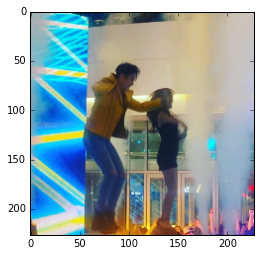

In [95]:
batch_index = 1
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 70.94% Keep
	(2) 17.47% Feature
	(3) 11.58% Delete


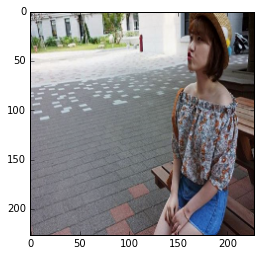

In [96]:
batch_index = 2
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 73.05% Keep
	(2) 24.28% Delete
	(3)  2.68% Feature


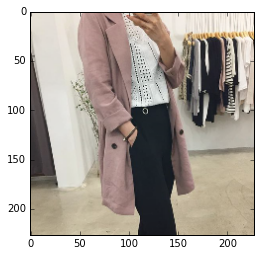

In [97]:
batch_index = 3
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 99.97% Delete
	(2)  0.02% Keep
	(3)  0.00% Feature


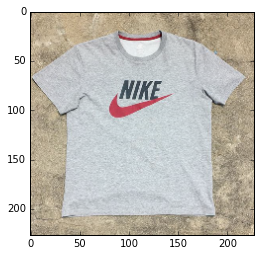

In [98]:
batch_index = 4
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

In [101]:
for batch_index in range(50):
    if ootd_labels[int(test_net.blobs['label'].data[batch_index])] == 'Delete':
        image = test_net.blobs['data'].data[batch_index]
        print 'batch index = ', batch_index
        disp_ootd_preds(test_net, image)
    

batch index =  4
top 3 predicted ootd labels =
	(1) 99.97% Delete
	(2)  0.02% Keep
	(3)  0.00% Feature
batch index =  5
top 3 predicted ootd labels =
	(1) 98.89% Delete
	(2)  1.03% Keep
	(3)  0.08% Feature
batch index =  9
top 3 predicted ootd labels =
	(1) 50.70% Delete
	(2) 40.81% Keep
	(3)  8.48% Feature
batch index =  10
top 3 predicted ootd labels =
	(1) 98.67% Delete
	(2)  1.32% Keep
	(3)  0.01% Feature
batch index =  15
top 3 predicted ootd labels =
	(1) 93.19% Delete
	(2)  6.73% Keep
	(3)  0.08% Feature
batch index =  16
top 3 predicted ootd labels =
	(1) 83.15% Keep
	(2) 16.43% Delete
	(3)  0.42% Feature
batch index =  17
top 3 predicted ootd labels =
	(1) 92.53% Delete
	(2)  7.17% Keep
	(3)  0.30% Feature
batch index =  21
top 3 predicted ootd labels =
	(1) 95.95% Delete
	(2)  3.91% Keep
	(3)  0.14% Feature
batch index =  23
top 3 predicted ootd labels =
	(1) 87.98% Delete
	(2) 11.73% Keep
	(3)  0.29% Feature
batch index =  26
top 3 predicted ootd labels =
	(1) 96.60% Delete


actual label = Delete
top 3 predicted ootd labels =
	(1) 83.15% Keep
	(2) 16.43% Delete
	(3)  0.42% Feature


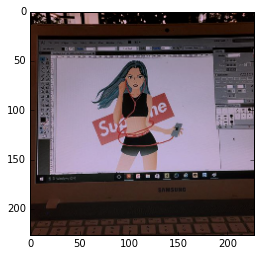

In [102]:
batch_index = 16
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 65.33% Keep
	(2) 33.81% Delete
	(3)  0.86% Feature


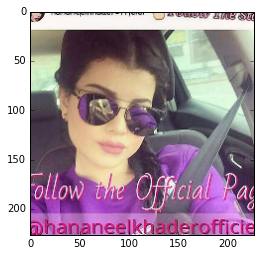

In [103]:
batch_index = 29
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 62.58% Keep
	(2) 35.39% Delete
	(3)  2.02% Feature


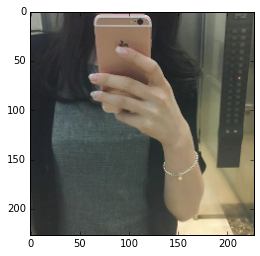

In [104]:
batch_index = 37
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

In [105]:
test_net.forward()

{'acc': array(0.8600000143051147, dtype=float32),
 'loss': array(0.32106754183769226, dtype=float32),
 'probs': array([[  5.37868887e-02,   8.62941980e-01,   8.32711607e-02],
        [  6.17709768e-04,   9.97344434e-01,   2.03787861e-03],
        [  4.22058851e-01,   5.64333379e-01,   1.36077702e-02],
        [  1.60104543e-01,   8.12432706e-01,   2.74627786e-02],
        [  6.83157966e-02,   8.72049153e-01,   5.96350729e-02],
        [  4.95718187e-03,   9.54285145e-01,   4.07576449e-02],
        [  2.24439785e-01,   6.85943961e-01,   8.96162018e-02],
        [  9.97152328e-01,   2.00232025e-03,   8.45248927e-04],
        [  9.12500799e-01,   8.23912621e-02,   5.10788616e-03],
        [  3.01352586e-04,   9.99335110e-01,   3.63411848e-04],
        [  1.60192564e-01,   7.73766696e-01,   6.60407543e-02],
        [  9.99478519e-01,   5.15830819e-04,   5.77713536e-06],
        [  4.07466054e-01,   5.84616482e-01,   7.91744888e-03],
        [  9.92552817e-01,   2.25328817e-03,   5.19385887

In [106]:
for batch_index in range(50):
    if ootd_labels[int(test_net.blobs['label'].data[batch_index])] == 'Delete':
        image = test_net.blobs['data'].data[batch_index]
        print 'batch index = ', batch_index
        disp_ootd_preds(test_net, image)

batch index =  7
top 3 predicted ootd labels =
	(1) 99.72% Delete
	(2)  0.20% Keep
	(3)  0.08% Feature
batch index =  8
top 3 predicted ootd labels =
	(1) 91.25% Delete
	(2)  8.24% Keep
	(3)  0.51% Feature
batch index =  11
top 3 predicted ootd labels =
	(1) 99.95% Delete
	(2)  0.05% Keep
	(3)  0.00% Feature
batch index =  12
top 3 predicted ootd labels =
	(1) 58.46% Keep
	(2) 40.75% Delete
	(3)  0.79% Feature
batch index =  13
top 3 predicted ootd labels =
	(1) 99.26% Delete
	(2)  0.52% Feature
	(3)  0.23% Keep
batch index =  16
top 3 predicted ootd labels =
	(1) 64.49% Delete
	(2) 33.18% Keep
	(3)  2.33% Feature
batch index =  17
top 3 predicted ootd labels =
	(1) 99.98% Delete
	(2)  0.02% Keep
	(3)  0.00% Feature
batch index =  18
top 3 predicted ootd labels =
	(1) 69.50% Keep
	(2) 24.29% Delete
	(3)  6.20% Feature
batch index =  24
top 3 predicted ootd labels =
	(1) 55.95% Delete
	(2) 41.51% Keep
	(3)  2.53% Feature
batch index =  25
top 3 predicted ootd labels =
	(1) 44.88% Delete

actual label = Delete
top 3 predicted ootd labels =
	(1) 58.46% Keep
	(2) 40.75% Delete
	(3)  0.79% Feature


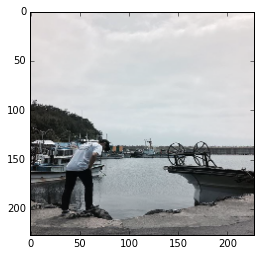

In [107]:
batch_index = 12
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 69.50% Keep
	(2) 24.29% Delete
	(3)  6.20% Feature


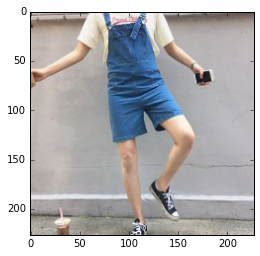

In [108]:
batch_index = 18
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 69.95% Keep
	(2) 26.74% Delete
	(3)  3.30% Feature


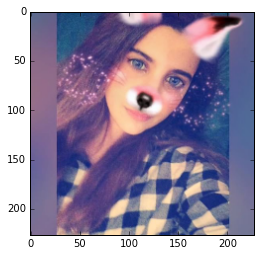

In [109]:
batch_index = 45
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_ootd_preds(test_net, image)

In [1]:
train_net_path = caffe_root + 'models/finetune_ootd/ootd_train.prototxt'
test_net_path = caffe_root + 'models/finetune_ootd/ootd_test.prototxt'
solver_config_path = caffe_root + 'models/finetune_ootd/ootd_solver.prototxt'


### Define net
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
       # with tempfile.NamedTemporaryFile(delete=False) as f:
           # f.write(str(n.to_proto()))
        #return f.name
    
    return n.to_proto()


def ootd_v2_net(batch_size, train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = caffe_root + 'data/ootd/%s.txt' % subset
    transform_param = dict(mirror=train, crop_size=227,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    ootd_data, ootd_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=batch_size, new_height=256, new_width=256, ntop=2)
    return caffenet(data=ootd_data, label=ootd_label, train=train,
                    num_classes=NUM_OOTD_LABELS,
                    classifier_name='fc8_ootd',
                    learn_all=learn_all)


with open(train_net_path, 'w') as f:
    f.write(str(ootd_v2_net(64, subset='train')))    
with open(test_net_path, 'w') as f:
    f.write(str(ootd_v2_net(100, train=False, subset='test')))
    

    
    


NameError: name 'caffe_root' is not defined

In [ ]:
###define solver
from caffe.proto import caffe_pb2

s = caffe_pb2.SolverParameter()

# Specify locations of the train and test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  # Test after every 500 training iterations.
s.test_iter.append(10) # Test on 10 batches each time we test.

# The number of iterations over which to average the gradient.
# Effectively boosts the training batch size by the given factor, without
# affecting memory utilization.
s.iter_size = 1

s.max_iter = 10000     # # of times to update the net (training iterations)

# Solve using the stochastic gradient descent (SGD) algorithm.
# Other choices include 'Adam' and 'RMSProp'.
s.type = 'SGD'

# Set the initial learning rate for SGD.
s.base_lr = 1e-5

# Set `lr_policy` to define how the learning rate changes during training.
# Here, we 'step' the learning rate by multiplying it by a factor `gamma`
# every `stepsize` iterations.
s.lr_policy = 'step'
s.gamma = 0.1
s.stepsize = 20000

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
#s.lr_policy = 'inv'
#s.gamma = 0.0001
#s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'




# Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
# weighted average of the current gradient and previous gradients to make
# learning more stable. L2 weight decay regularizes learning, to help prevent
# the model from overfitting.
s.momentum = 0.9
s.weight_decay = 5e-4

# Display the current training loss and accuracy every 1000 iterations.
s.display = 1000

# Snapshots are files used to store networks we've trained.  Here, we'll
# snapshot every 10K iterations -- ten times during training.
s.snapshot = 10000
s.snapshot_prefix = caffe_root + 'models/finetune_ootd/finetune_ootd2'

# Train on the GPU.  Using the CPU to train large networks is very slow.
s.solver_mode = caffe_pb2.SolverParameter.CPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))


### load the solver and create train and test nets
solver = caffe.get_solver(solver_config_path)


### solve
niter = 250  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

delete_acc = zeros(int(np.ceil(niter / test_interval)))



# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        correct_delete = 0
        all_delete = 0
        for test_it in range(10):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['probs'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
            correct_delete += sum( logical_and((solver.test_nets[0].blobs['probs'].data.argmax(1) == 0), 
                                   (solver.test_nets[0].blobs['label'].data == 0)))
            all_delete += sum(solver.test_nets[0].blobs['label'].data == 0)
            
        test_acc[it // test_interval] = correct / 1e3
        delete_acc[it // test_interval] = correct_delete / all_delete
        

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('OOTD Test Accuracy: {:.2f}'.format(test_acc[-1]))



for i in range(it // test_interval):
    print 'OOTD Delete Accuracy: {:.2f}'.format(delete_acc[i])



So we did finetuning and it is awesome. Let's take a look at what kind of results we are able to get with a longer, more complete run of the style recognition dataset. Note: the below URL might be occassionally down because it is run on a research machine.

http://demo.vislab.berkeleyvision.org/